In [ ]:
!pip install seaborn

In [ ]:
!pip install transformers

In [ ]:
!pip install tdqm

In [5]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import time
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
import os
from transformers import BertForSequenceClassification, AdamW
import torch.nn as nn

In [6]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joao_\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\joao_\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Twitter Dataset

In [7]:
dataset_path = kagglehub.dataset_download("jp797498e/twitter-entity-sentiment-analysis")
dataset_path

'C:\\Users\\joao_\\.cache\\kagglehub\\datasets\\jp797498e\\twitter-entity-sentiment-analysis\\versions\\2'

In [16]:
train_csv = pd.read_csv(r"C:\Users\joao_\.cache\kagglehub\datasets\jp797498e\twitter-entity-sentiment-analysis\versions\2\twitter_training.csv")
train_csv.columns=['ID','Keyword','Sentiment','Tweet']
train_csv

,ID,Keyword,Sentiment,Tweet
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
...,...,...,...,...
74676,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74677,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74678,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74679,9200,Nvidia,Positive,Just realized between the windows partition of...


In [17]:
val_csv = pd.read_csv(r"C:\Users\joao_\.cache\kagglehub\datasets\jp797498e\twitter-entity-sentiment-analysis\versions\2\twitter_validation.csv")
val_csv.columns=['ID','Keyword','Sentiment','Tweet']
val_csv

,ID,Keyword,Sentiment,Tweet
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...
...,...,...,...,...
994,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
995,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
996,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
997,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


In [9]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text)
    tokens = text.split()
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(tokens)

In [10]:
print(f"Training examples: {len(train_csv)}")
print(f"Testing examples: {len(val_csv)}")

Training examples: 74681


NameError: name 'val_csv' is not defined

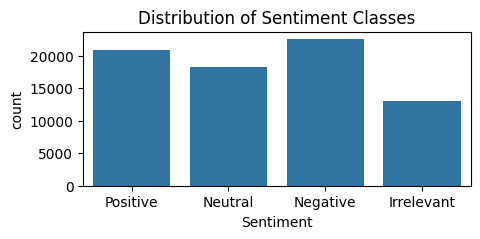

In [11]:
plt.figure(figsize=(5, 2))
plt.title('Distribution of Sentiment Classes')

sns.countplot(x='Sentiment', data=train_csv)

plt.show()

In [12]:
df = train_csv.dropna(subset=['Tweet', 'Sentiment'])

X = df['Tweet'].apply(preprocess_text)
y = df['Sentiment']

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# SVM

In [55]:
print(f"Train: {len(x_train)} - {len(y_train)}")
print(f"Val: {len(x_test)} - {len(y_test)}")

Train: 59196 - 59196
Val: 14799 - 14799


In [65]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('svm', LinearSVC(C=1.0, max_iter=10000))
])

print("Training SVM model...")

start_time = time.time()
pipeline.fit(X_train, y_train)
training_time = time.time() - start_time

print(f"Training completed in {training_time:.2f} seconds")

Training SVM model...


c:\users\joao_\miniconda3\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Training completed in 1.27 seconds


In [67]:
y_pred = pipeline.predict(x_test)
y_pred

array(['Negative', 'Positive', 'Positive', ..., 'Positive', 'Negative',
       'Positive'], dtype=object)

In [76]:
val_accuracy = accuracy_score(y_pred, y_test)
print(f"\nAccuracy: {val_accuracy:.4f}%")


Accuracy: 0.7062%


In [80]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

  Irrelevant       0.70      0.57      0.63      2575
    Negative       0.76      0.79      0.77      4472
     Neutral       0.65      0.67      0.66      3621
    Positive       0.70      0.74      0.72      4131

    accuracy                           0.71     14799
   macro avg       0.70      0.69      0.69     14799
weighted avg       0.71      0.71      0.70     14799



In [103]:
param_grid = {
    'tfidf__max_features': [3000, 5000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'svm__C': [0.1, 1.0, 10.0]
}
grid_search = GridSearchCV(
    pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1
)
grid_search.fit(X_train, y_train)

c:\users\joao_\miniconda3\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=5000)),
                                       ('svm', LinearSVC(max_iter=10000))]),
             n_jobs=-1,
             param_grid={'svm__C': [0.1, 1.0, 10.0],
                         'tfidf__max_features': [3000, 5000],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='accuracy')

In [104]:
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

In [105]:
val_accuracy = accuracy_score(y_pred_best, y_test)
print(f"\nAccuracy: {val_accuracy:.4f}%")


Accuracy: 0.7141%


# Bert Pretrained

In [93]:
class TwitterDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=100, text_column='Tweet', label_column='Sentiment'):
        self.data = csv_file if isinstance(csv_file, pd.DataFrame) else pd.read_csv(csv_file)
        self.data = self.data.dropna(subset=[text_column, label_column])

        self.text_column = text_column
        self.label_column = label_column
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(self.data[label_column])
        self.label_mapping = dict(zip(self.label_encoder.classes_, range(len(self.label_encoder.classes_))))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = str(self.data.iloc[idx][self.text_column])
        label = self.labels[idx]

        text = self.preprocess_text(text)
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

    def preprocess_text(self, text):
        text = text.lower()
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)
        text = re.sub(r'@\w+|#\w+', '', text)
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\s+', ' ', text)
            
        return text.strip()

    def get_class_names(self):
        return self.label_encoder.classes_

In [94]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [95]:
train_dataset = TwitterDataset(train_csv, tokenizer)
val_dataset = TwitterDataset(val_csv, tokenizer)

print(f"Train Dataset: {len(train_dataset)}")
print(f"Val Dataset: {len(val_dataset)}")

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=True
)

Train Dataset: 73995
Val Dataset: 999


In [96]:
num_classes = len(train_dataset.get_class_names())
num_classes

4

In [97]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', 
    num_labels=num_classes
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [98]:
optimizer = AdamW(model.parameters(), lr=2e-5)
device = torch.device('cuda')
model.to(device)

c:\users\joao_\miniconda3\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [99]:
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids, 
            attention_mask=attention_mask, 
            labels=labels
        )
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids, 
                attention_mask=attention_mask, 
                labels=labels
            )
            loss = outputs.loss
            logits = outputs.logits

            val_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss/len(train_loader):.4f}, "
          f"Train Acc: {100*train_correct/train_total:.2f}%")
    print(f"Val Loss: {val_loss/len(val_loader):.4f}, "
          f"Val Acc: {100*val_correct/val_total:.2f}%")
    print()

torch.save(model.state_dict(), 'twitter_sentiment_bert.pt')

Epoch 1/5
Train Loss: 0.8373, Train Acc: 66.58%
Val Loss: 0.2792, Val Acc: 91.49%

Epoch 2/5
Train Loss: 0.3333, Train Acc: 87.99%
Val Loss: 0.1102, Val Acc: 97.00%

Epoch 3/5
Train Loss: 0.1608, Train Acc: 93.94%
Val Loss: 0.0923, Val Acc: 97.60%

Epoch 4/5
Train Loss: 0.1148, Train Acc: 95.55%
Val Loss: 0.1223, Val Acc: 97.10%

Epoch 5/5
Train Loss: 0.0975, Train Acc: 96.12%
Val Loss: 0.1069, Val Acc: 97.50%



In [102]:
n_to_label = {
    0: "Irrelevant",
    1: "Negative",
    2: "Neutral",
    3: "Positive"
}

In [110]:
sentence = "I like the game"
tokens = tokenizer(sentence)
encoded_input = tokenizer(
    sentence, 
    return_tensors='pt',
    padding=True,
    truncation=True,
    max_length=128
)

input_ids = encoded_input['input_ids'].to(device)
attention_mask = encoded_input['attention_mask'].to(device)

model.eval()
with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    prediction = torch.argmax(logits, dim=1)
    print(f"Predicted class: {n_to_label[prediction.item()]}")

Predicted class: Positive
